In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sodapy import Socrata
from urllib.request import urlopen
import json

#### Load PLUO data

In [2]:
# setup Socrata client, in this example we use generic, unauthenticated account
client = Socrata("data.cityofnewyork.us", None)
dataset_id = "64uk-42ks"

# Obtain the dataset as JSON from API by sodapy.
data = client.get(dataset_id, limit=900000, select='bbl, latitude, longitude') # from data description we know the data has 859K rows
# data = client.get(dataset_id, limit=30000, select="property_id, nyc_borough_block_and_lot_bbl") # select specific columns only

# Convert results to pandas DataFrame
pluto_df = pd.DataFrame.from_records(data)

In [3]:
pluto_df.head()

,bbl,latitude,longitude
0,3018090016.00000000,40.6871961,-73.9465987
1,3061830033.00000000,40.6145950,-73.9922993
2,3062060022.00000000,40.6125007,-73.9918421
3,3018520037.00000000,40.6818274,-73.9413030
4,3058930008.00000000,40.6320474,-74.0212816


In [4]:
#geo dataframe
#points
pluto_gdf = gpd.GeoDataFrame(pluto_df, geometry=gpd.points_from_xy(pluto_df.longitude, pluto_df.latitude))

In [5]:
pluto_gdf.head()

,bbl,latitude,longitude,geometry
0,3018090016.00000000,40.6871961,-73.9465987,POINT (-73.94660 40.68720)
1,3061830033.00000000,40.6145950,-73.9922993,POINT (-73.99230 40.61460)
2,3062060022.00000000,40.6125007,-73.9918421,POINT (-73.99184 40.61250)
3,3018520037.00000000,40.6818274,-73.9413030,POINT (-73.94130 40.68183)
4,3058930008.00000000,40.6320474,-74.0212816,POINT (-74.02128 40.63205)


In [6]:
pluto_gdf = pluto_gdf.set_crs(4326)

In [7]:
#sanity check
len(pluto_gdf)

858619

In [8]:
#sanity check
#bbl should be the unique identifier
len(pluto_gdf['bbl'].unique())

858619

#### Load floodplain data

In [9]:
#floodplain
fp_500 = gpd.read_file('../Data/fp_500yr/geo_export_f9627ca8-5409-4bf4-9e1c-e812fdb2e4d7.shp')
fp_500 = fp_500.set_crs(4326, allow_override=True)

In [10]:
fp_500.head()

,abfe_0_2pc,fld_zone,gridcode,join_count,shape_area,shape_leng,static_bfe,geometry
0,0.0,None,1500.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.90993 40.91517, -73.91010 40.915..."
1,0.0,None,1300.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.88825 40.89957, -73.88801 40.899..."
2,0.0,None,1300.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.88852 40.89902, -73.88846 40.899..."
3,0.0,None,1300.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.88861 40.89875, -73.88861 40.899..."
4,0.0,None,1300.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.88861 40.89861, -73.88874 40.898..."


<AxesSubplot:>

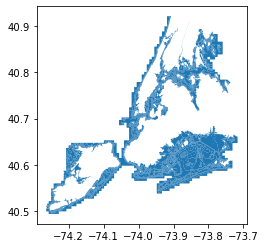

In [11]:
fp_500.plot()

In [12]:
fp_500['fld_zone'].unique()

array([None, 'AE', 'VE', 'AO'], dtype=object)

<AxesSubplot:>

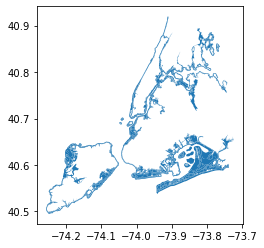

In [13]:
#only select rows with a designated flood zone
fp_500_z = fp_500.loc[(fp_500['fld_zone'] == 'AE') | (fp_500['fld_zone'] == 'VE') | (fp_500['fld_zone'] == 'AO')]
fp_500_z.plot()

#### Use the overlay() function (https://geopandas.org/en/stable/docs/user_guide/set_operations.html) to calculate intersection of PLUTO points and floodplain polygons

In [14]:
comb = gpd.overlay(pluto_gdf, fp_500_z, how='intersection')
comb = comb.drop_duplicates('bbl')
comb['col_1'] = 1
print(len(comb))
comb.head()

54777


,bbl,latitude,longitude,abfe_0_2pc,fld_zone,gridcode,join_count,shape_area,shape_leng,static_bfe,geometry,col_1
0,3068680068.00000000,40.5959958,-73.9871882,14.0,AE,1400.0,2.0,1.075891e+07,54372.827437,10.0,POINT (-73.98719 40.59600),1
1,3071610044.00000000,40.5894214,-73.9826421,14.0,AE,1400.0,2.0,1.075891e+07,54372.827437,10.0,POINT (-73.98264 40.58942),1
2,3069190097.00000000,40.5855652,-73.9844576,14.0,AE,1400.0,2.0,1.075891e+07,54372.827437,10.0,POINT (-73.98446 40.58557),1
3,3068660077.00000000,40.5965147,-73.9890642,14.0,AE,1400.0,2.0,1.075891e+07,54372.827437,10.0,POINT (-73.98906 40.59651),1
4,3068670069.00000000,40.5961825,-73.9881640,14.0,AE,1400.0,2.0,1.075891e+07,54372.827437,10.0,POINT (-73.98816 40.59618),1


In [15]:
#use the bbl column to join back to original pluto_gdf
df1 = pluto_gdf.merge(comb[['bbl', 'col_1']], how = 'left',
                left_on = 'bbl', right_on = 'bbl')
df1 = df1.drop_duplicates('bbl', keep='first')
df1.head()

,bbl,latitude,longitude,geometry,col_1
0,3018090016.00000000,40.6871961,-73.9465987,POINT (-73.94660 40.68720),NaN
1,3061830033.00000000,40.6145950,-73.9922993,POINT (-73.99230 40.61460),NaN
2,3062060022.00000000,40.6125007,-73.9918421,POINT (-73.99184 40.61250),NaN
3,3018520037.00000000,40.6818274,-73.9413030,POINT (-73.94130 40.68183),NaN
4,3058930008.00000000,40.6320474,-74.0212816,POINT (-74.02128 40.63205),NaN


In [16]:
#sanity check
print(df1.shape)
print(df1['col_1'].notna().sum())
print(df1['col_1'].isna().sum())

(858619, 5)
54777
803842


In [17]:
#in_fz column: 0 not in flood zone; 1 in flood zone
df1['col_1'] = df1['col_1'].replace(np.nan, 0)
df1 = df1.rename(columns={'col_1': 'in_fz'})
df1['in_fz'] = df1['in_fz'].astype(int)
df1.head()

,bbl,latitude,longitude,geometry,in_fz
0,3018090016.00000000,40.6871961,-73.9465987,POINT (-73.94660 40.68720),0
1,3061830033.00000000,40.6145950,-73.9922993,POINT (-73.99230 40.61460),0
2,3062060022.00000000,40.6125007,-73.9918421,POINT (-73.99184 40.61250),0
3,3018520037.00000000,40.6818274,-73.9413030,POINT (-73.94130 40.68183),0
4,3058930008.00000000,40.6320474,-74.0212816,POINT (-74.02128 40.63205),0


In [19]:
print(df1['in_fz'].notna().sum())

858619


In [22]:
#save output
#shp
df1.to_file('../Data/pluto_floodplain/pluto_floodplain.shp')

C:\Users\mengk\anaconda3\envs\geo_test\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [23]:
#csv
df1.to_csv('../Data/pluto_floodplain.csv', index=False)